In [34]:

import torch
from thermostability.thermo_pregenerated_dataset import ThermostabilityPregeneratedDataset
import umap.umap_ as umap
import numpy
from typing import Union
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt


In [7]:
def zero_padding(s_s_list: "list[tuple[torch.Tensor, torch.Tensor]]", fixed_size: Union[int, None]=None):
    max_size = fixed_size if fixed_size else max([s_s.size(0) for s_s, _ in s_s_list])

    padded_s_s = []
    temps =[]
    for s_s, temp in s_s_list:
        dif = max_size - s_s.size(0) 
        padded = pad(s_s, (0,0,dif,0), "constant", 0)
        padded_s_s.append(padded)
        temps.append(temp)
    results= torch.stack(padded_s_s, 0).unsqueeze(1), torch.stack(temps)
    return results

def zero_padding700(s_s_list: "list[tuple[torch.Tensor, torch.Tensor]]"):
    return zero_padding(s_s_list, 700)

In [8]:
trainSet = ThermostabilityPregeneratedDataset("train.csv")
valSet = ThermostabilityPregeneratedDataset("val.csv")

dataloaders = {
    "train": DataLoader(trainSet, batch_size=1, shuffle=True, num_workers=0),
    "val": DataLoader(valSet, batch_size=1, shuffle=True, num_workers=0, collate_fn= zero_padding700)
}

Omitted 45385 sequences of train.csv because they have not been pregenerated
Omitted 4660 sequences of val.csv because they have not been pregenerated


In [27]:
flattened_tensors = None
temps = None
i = 0
for batch in dataloaders['val']:
    if i > 100:
        break
    flat_tensor = batch[0].flatten().numpy()
    temp = batch[1].numpy()
    if flattened_tensors is None:
        flattened_tensors = numpy.array([flat_tensor])
        temps= numpy.array([temp])
    else:
        flattened_tensors= numpy.append(flattened_tensors, [flat_tensor], axis= 0)
        temps = numpy.append(temps, [temp])
    i +=1


In [28]:
flattened_tensors.shape


(101, 716800)

In [37]:
reducer = umap.UMAP(n_components=3, random_state=42)
reducer.fit(flattened_tensors, temps)

UMAP(n_components=3, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [38]:
embedding = reducer.transform(flattened_tensors)
embedding.shape

(101, 3)

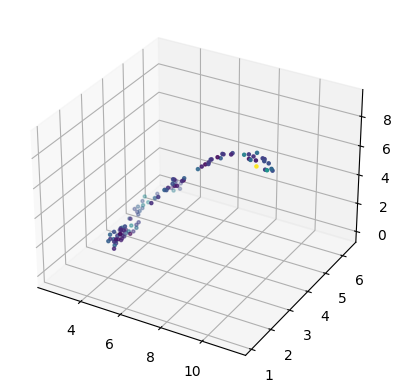

In [43]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1],embedding[:,2], c = temps, s=5)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=numpy.arange(11)-0.5).set_ticks(numpy.arange(10))
# ax.title('UMAP projection of the s_s representaitons', fontsize=24)